<span style="font-family:Papyrus; font-size:3em;">Numerical Analysis of Some Fitting Surfaces</span>

# Preliminaries

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tellurium as te
import pandas as pd
import seaborn as sn

# One Species Pathway

Consider the pathway $X0 \xrightarrow{k_1} x \xrightarrow{k_2} X_1$, where $X_0$ and $X1$ have fixed concentrations and reactions kinetics
are mass action with kinetic constants $k_i$.
Then, $\frac{dx}{dt} = k_1 X_0 - k_2 x$.
We want to explore the fitting surface for $k_1, K_2$.

In [2]:
MODEL = """

J1: $X0 -> x; k1*X0
J2: x -> $X1; k2*x

X0 = 1
x = 0
k1 = 1
k2 = 1
"""

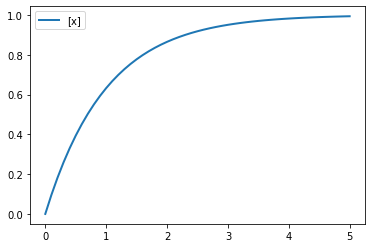

In [3]:
rr = te.loada(MODEL)
trueData = rr.simulate()
rr.plot(trueData)

In [4]:
def simulateModel(parameterDct, model=MODEL):
    """
    Runs the simulation with the parameter values in the Dct
    
    Parameters
    ----------
    parameterDct
        key: parameterName
        value: value of parameter
        
    Returns
    -------
    NamedArray
    """
    rr = te.loada(model)
    for parameterName, value in parameterDct.items():
        rr[parameterName] = value
    return rr.simulate()

# Test
result = simulateModel({"k1": 1, "k2": 1})
length = len(result)
assert(result[length - 1, -1] > 0.99 )

In [5]:
def calcRsq(parameterRefDct, parameterOtherDct, model=MODEL):
    """
    Calculates the R^2 value for the difference between the two simulated results.
    
    Parameters
    ----------
    parameterRefDct: dict
    parameterOtherDct: dict
    model: str
         antimony model
    """
    def getFlatValues(parameterDct):
        data = simulateModel(parameterDct, model=model)
        flattenedArr = (data[:, 1:]).flatten()
        return flattenedArr
    #
    refArr = getFlatValues(parameterRefDct)
    otherArr = getFlatValues(parameterOtherDct)
    residualsArr = refArr - otherArr
    rsq = 1 - np.var(residualsArr)/np.var(refArr)
    return rsq

# Tests
parameterDct = {"k1": 2, "k2": 2}
rsq = calcRsq(parameterDct, parameterDct)
assert(rsq == 1.0)
parameterDct1 = {"k1": 2, "k2": 1}
rsq = calcRsq(parameterDct, parameterDct1)
assert(rsq < 0.9)

In [6]:
# Create range of parameter changes
value = 0
lower = -2
upper = 2
np.linspace(start=lower, stop = upper, num=11)

array([-2. , -1.6, -1.2, -0.8, -0.4,  0. ,  0.4,  0.8,  1.2,  1.6,  2. ])

In [7]:
def mkParameterRange(initialValue, changeFrc, numPoint):
    """
    Creates an array of values centered on the initial value
    
    Parameters
    ----------
    initialValue: float
    changeFrc: float
        maximum fractional change
    numPoint: int
    
    Result
    ------
    np.array
    """
    if numPoint % 2 == 0:
        numPoint += 1
    maxChange = initialValue*changeFrc
    return np.linspace(start=initialValue-maxChange,
                      stop=initialValue+maxChange,
                      num=numPoint)

# Tests
size = 10
arr = mkParameterRange(2, 0.5, size)
assert(len(arr) == size+1)
assert(arr[0] == 1)

In [8]:
xx = np.array( [ [0, 1, 2], [3, 4, 5] ])
np.shape(xx)

(2, 3)

In [9]:
def mkFactorialDesign(parameterDct, maxChangeFrc, numLevel):
    """
    Creates a factorial design for the parameters. Levels are determined
    by fractional changes in the initial value based on the maximum
    fractional change, either positive or negative.
    
    Parameter
    ---------
    parameterDct: dict
    maxChangeFrc: float
        maximum change fraction in positive and negative direction
    numLevel: int
        total number of points in an axis
    
    Returns
    -------
    pd.DataFrame
       Columns:
           parameter name: contains parameter value
           rsq: rsq w.r.t. a change of 0
    """
    # Calculate number of points in one direction
    if numLevel // 2 == 0:
        numHalf = numLevel // 2
    else:
        numHalf = (numLevel - 1) // 2
    #
    incrFrc = maxChangeFrc / numHalf
    posFrcs = np.array([n*incrFrc for n in range(1, numHalf+1)])
    negFrcs = - posFrcs
    negFrcs = np.sort(negFrcs)
    frcs = np.concatenate([negFrcs, np.array([0]), posFrcs])
    # Construct parameter values
    parameterNames = list(parameterDct.keys())
    levelDct = {}
    for parameterName in parameterNames:
        levelDct[parameterName] = (1 + frcs)*parameterDct[parameterName]
    # Construct the parameter columns
    designDF = pd.DataFrame({parameterNames[0]: levelDct[parameterNames[0]]})
    for parameterName in parameterNames[1:]:
        values = levelDct[parameterName]
        dfs = []
        for value in values:
            newDF = designDF.copy()
            newDF[parameterName] = value
            dfs.append(newDF)
        designDF = pd.concat(dfs)
    designDF.index = range(len(designDF))
    # Run the simulations
    return designDF
        
# Tests
numLevel = 5
parameterDct = {"k1": 1, "k2": 2, "k3": 3}
designDF = mkFactorialDesign(parameterDct, 1.0, numLevel)
# Correct length
assert(len(designDF) == numLevel**len(parameterDct))
# First values are 0
trues = [v == 0 for v in designDF.loc[0,:]]
assert(all(trues))
# Middle value is the original value of the parameter
midIdx = (len(designDF) - 1) // 2
trues = [designDF.loc[midIdx, k] == parameterDct[k] for k in parameterDct.keys()]
assert(all(trues))

In [10]:
s1 = pd.DataFrame({1: range(3), 2: range(3)})
s2 = pd.DataFrame({1:range(4), 2: range(4)})
pd.concat([s1, s2])

,1,2
0,0,0
1,1,1
2,2,2
0,0,0
1,1,1
2,2,2
3,3,3


# 3-d plot

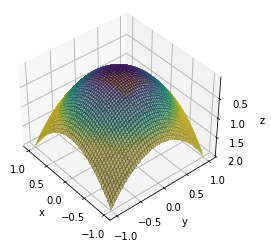

In [11]:
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from math import sin, cos, pi
import matplotlib.cm as cm

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

#creating grid
y = np.linspace(-1,1,200)
x = np.linspace(-1,1,200)
x,y = np.meshgrid(x,y)

#set z values
z0 = x**2+y**2

# rotate the samples by pi / 4 radians around y
if False:
    a = pi / 4
    t = np.transpose(np.array([x,y,z0]), (1,2,0))
    m = [[cos(a), 0, sin(a)],[0,1,0],[-sin(a), 0, cos(a)]]
    x,y,z = np.transpose(np.dot(t, m), (2,0,1))
    # or `np.dot(t, m)` instead `t @ m`


#label axes
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

#plot figure
ax.plot_surface(x,y,z0,linewidth=0, antialiased=False, shade = True, alpha = 0.5, facecolors=cm.viridis(z0))
elevationAng = -140
azimuthAng = 40
ax.view_init(elevationAng, azimuthAng)

plt.show()

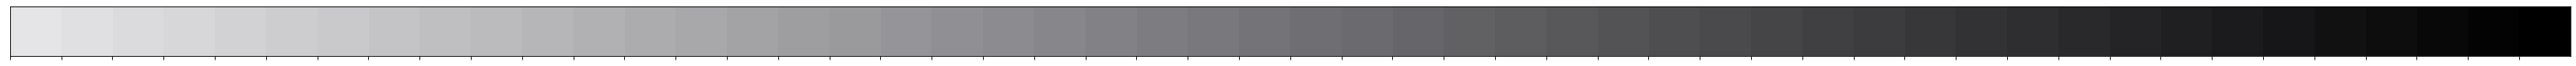

In [15]:
sns.palplot(sns.cubehelix_palette(50, hue=0.05, rot=0, light=0.9, dark=0))

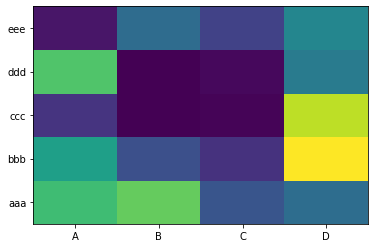

In [12]:
import numpy as np 
from pandas import DataFrame
import matplotlib.pyplot as plt

index = ['aaa', 'bbb', 'ccc', 'ddd', 'eee']
columns = ['A', 'B', 'C', 'D']
df = DataFrame(abs(np.random.randn(5, 4)), index=index, columns=columns)

plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()


<AxesSubplot:>

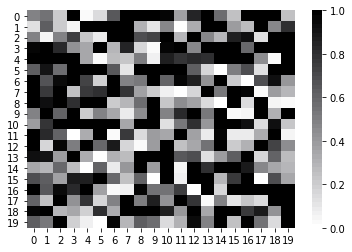

In [22]:
import numpy as np 
from pandas import DataFrame
import seaborn as sns
%matplotlib inline

SIZE = 20
Cols = range(SIZE)
Index= range(SIZE)
df = DataFrame(abs(np.random.randn(SIZE, SIZE)), index=Index, columns=Cols)
cmap = sns.cubehelix_palette(50, hue=0.05, rot=0, light=1, dark=0)

sns.heatmap(df, annot=False, vmin=0, vmax=1.0, cmap=cmap)

